https://medium.com/analytics-vidhya/table-detection-and-text-extraction-5a2934f61caa

## Loading original image to display

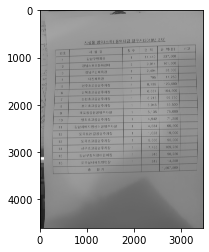

In [ ]:
import cv2
import matplotlib.pyplot as plt
file=r'/Users/heeran/Documents/heeran/2차_과제/참조/downloaded_fr_mail.jpg'

img = cv2.imread(file,0)
plot1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Inverted Image with global thresh holding

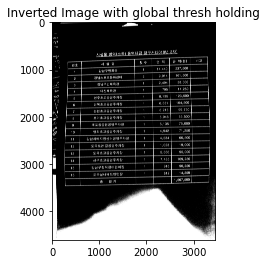

In [ ]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
img_bin = 255-img_bin
plotting = plt.imshow(img_bin,cmap='gray')
plt.title("Inverted Image with global thresh holding")
plt.show()

## Inverted Image with otsu thresh holding

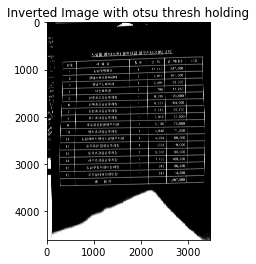

In [ ]:
img_bin1 = 255-img
thresh1,img_bin1_otsu = cv2.threshold(img_bin1,128,255,cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin1_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Inverted image with both global and Otsu thresholding

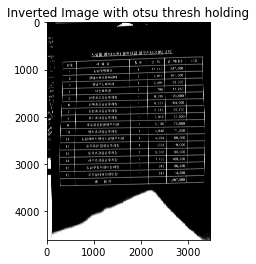

In [ ]:
img_bin2 = 255-img
thresh1,img_bin_otsu = cv2.threshold(img_bin2,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plotting = plt.imshow(img_bin_otsu,cmap='gray')
plt.title("Inverted Image with otsu thresh holding")
plt.show()

## Create a rectangular structuring element

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
print(kernel)

[[1 1]
 [1 1]]


# Morphological Operations

## Create a new structuring element to perform erosion on the image

First we need to get the vertical lines.

We create a vertical kernel with kernel width 1 and height the number of columns in image array divided by 200.

Erosion makes the pixel 1 only if all the pixels under kernel are 1.

We perform erosion for 5 iterations with the vertical kernel.

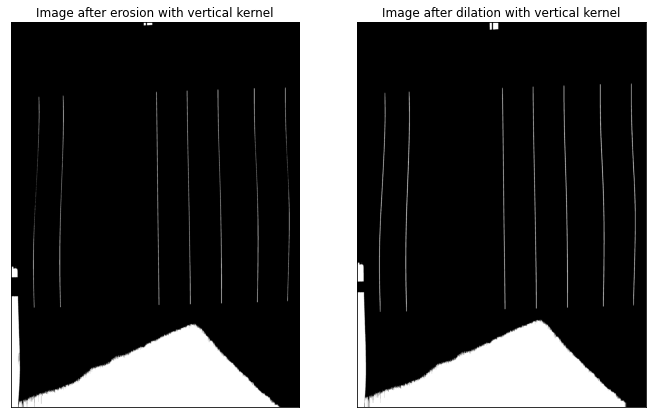

In [ ]:
import numpy as np
plt.figure(figsize= (30,30))

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//100))
eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=3)
plt.subplot(151),plt.imshow(eroded_image, cmap = 'gray')
plt.title('Image after erosion with vertical kernel'), plt.xticks([]), plt.yticks([])

vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)
plt.subplot(152),plt.imshow(vertical_lines, cmap = 'gray')
plt.title('Image after dilation with vertical kernel'), plt.xticks([]), plt.yticks([])

plt.show()

Dilation will make the pixel 1, if at least one of the pixels under the kernel is 1.

Similarly lets do the same with a horizontal lines to get the horizontal lines.

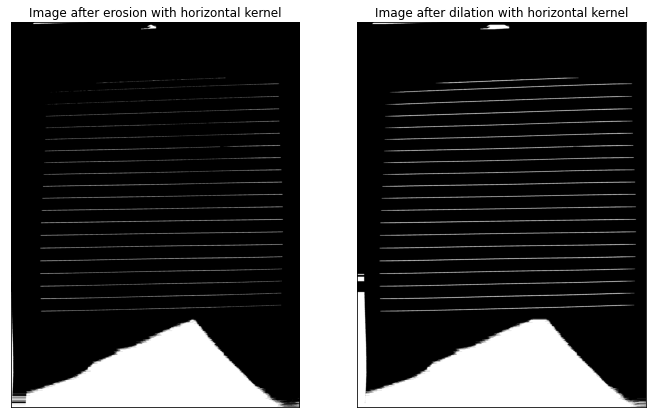

In [ ]:
plt.figure(figsize= (30,30))

hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//100, 1))
horizontal_lines = cv2.erode(img_bin, hor_kernel, iterations=5)
plt.subplot(153),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after erosion with horizontal kernel'), plt.xticks([]), plt.yticks([])

horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)
plt.subplot(154),plt.imshow(horizontal_lines, cmap = 'gray')
plt.title('Image after dilation with horizontal kernel'), plt.xticks([]), plt.yticks([])

plt.show()

## Now we add the two images

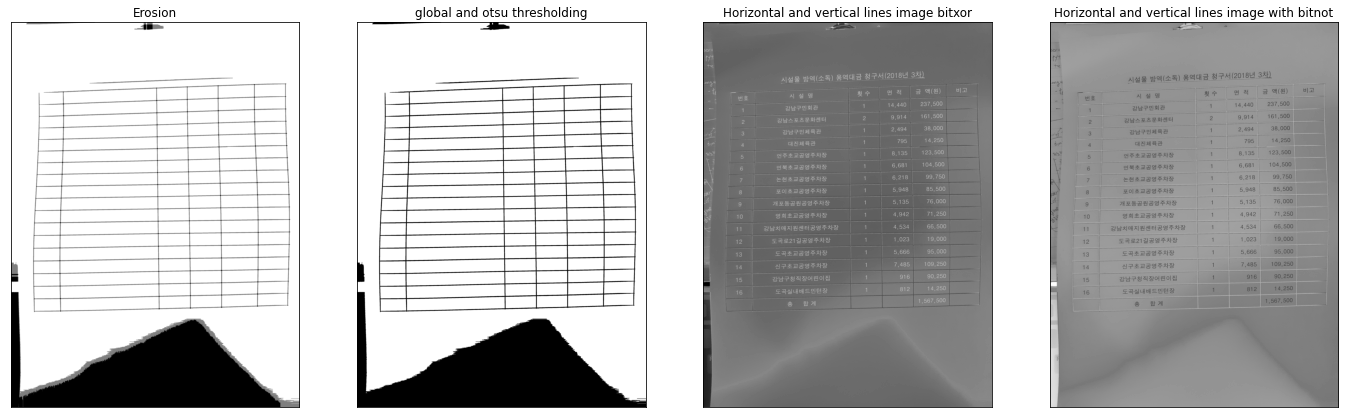

In [ ]:
plt.figure(figsize= (30,30))

vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
plt.subplot(151),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('Erosion'), plt.xticks([]), plt.yticks([])

thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.subplot(152),plt.imshow(vertical_horizontal_lines, cmap = 'gray')
plt.title('global and otsu thresholding'), plt.xticks([]), plt.yticks([])

bitxor = cv2.bitwise_xor(img,vertical_horizontal_lines)
plt.subplot(153),plt.imshow(bitxor, cmap = 'gray')
plt.title('Horizontal and vertical lines image bitxor'), plt.xticks([]), plt.yticks([])

bitnot = cv2.bitwise_not(bitxor)
plt.subplot(154),plt.imshow(bitnot, cmap = 'gray')
plt.title('Horizontal and vertical lines image with bitnot'), plt.xticks([]), plt.yticks([])

plt.show()

In [ ]:
import pytesseract

## Let's get the contours from the grid that we have obtained by adding the horizontal and vertical lines.

In [ ]:
contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

## Bounding Boxes

To get the coordinates of different boxes

In [ ]:
boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda x:x[1][1]))

Here we draw the contours on our image and also store them in list boxes. It is stored as a list (x,y,w,h) : x and y beind coordinates of top left corner and w and h being width and height of the box respectively.

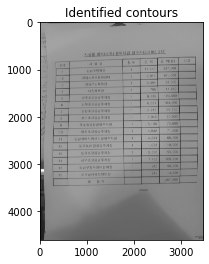

In [ ]:
boxes = []
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  if (w<1000 and h<500):
    image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    boxes.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

## Getting the rows and columns

## To store rows and columns :

- Now we add rows and columns.
- We calculate the mean height of all boxes.
- Initially, we append the first box to the columns list.
- The columns list is essentialy a temporary list.
- We assign previous box to the first box as well.
- We will loop through the remaining boundingBoxes list.
- At each iteration, we check if the y coordinate of the top left corner of the current box is less than the y coordinate of the previous box added with half the mean of all heights.
- If yes :
    - The current box is appended to columns list.
    - The current box is assigned to previous box.
    - Next we check if we are at the last index. If yes :
      - We append the entire column to rows list.
- If no :
    - We append the columns list to rows.
    - We assign the columns list to empty as this will start a new empty columns list.
    - We assign the current box to the previous box variable.
    - We append the current box to the empty column list we just created.


In [ ]:
len(boundingBoxes)

119

In [ ]:
rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
  if(boxes[i][1]<=previous[1]+mean/2):
    columns.append(boxes[i])
    previous=boxes[i]
    if(i==len(boxes)-1):
      rows.append(columns)
  else:
    rows.append(columns)
    columns=[]
    previous = boxes[i]
    columns.append(boxes[i])
print("Rows")
for row in rows:
  print(row)

194.0924369747899
Rows
[[1616, 0, 11, 29], [1616, 33, 11, 1]]
[[2916, 745, 363, 149], [2481, 754, 425, 154], [2112, 769, 360, 152], [1745, 782, 358, 152]]
[[2916, 896, 363, 147], [2482, 906, 425, 150], [2113, 920, 360, 149], [1748, 933, 357, 148], [342, 987, 282, 140], [2917, 1045, 364, 144], [2484, 1055, 425, 147], [2115, 1068, 361, 146], [1750, 1080, 357, 145], [340, 1128, 284, 138], [2920, 1191, 365, 144], [2486, 1201, 426, 146], [2117, 1213, 361, 145], [1752, 1225, 357, 144], [336, 1268, 286, 136], [2924, 1337, 367, 142], [2489, 1346, 429, 144], [2120, 1357, 363, 144], [1753, 1368, 359, 142], [331, 1407, 289, 136], [2929, 1483, 369, 140], [2494, 1490, 431, 144], [2122, 1501, 365, 143], [1755, 1512, 360, 141], [324, 1546, 292, 137], [2936, 1629, 369, 141], [2498, 1634, 433, 145], [2125, 1644, 367, 145], [1756, 1655, 362, 142], [317, 1686, 294, 138], [2943, 1775, 371, 141], [2502, 1781, 436, 144], [2127, 1789, 369, 145], [1758, 1799, 363, 141], [310, 1828, 296, 137], [2949, 1922, 370

Lets get the total cells in each row

In [ ]:
len(row)

6

In [ ]:
row[1]

[106, 4443, 20, 1]

In [ ]:
total_cells=0
for i in range(len(rows)):
  if len(rows[i]) > total_cells:
    total_cells = len(rows[i])
print(total_cells)

40


# Lets get the centre of cell

- We add the width of cell to left bottom x coordinate to the the x coordinate of centre of cell.

In [ ]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)

[112, 116, 3362, 3345, 3403, 3363]


In [ ]:
center=np.array(center)
center.sort()
print(center)

[ 112  116 3345 3362 3363 3403]


# Now we create a list of the coordinates of the boxes

In [ ]:
# If you don't have tesseract executable in your PATH, include the following:
# to know about your path, please execute $ brew list [pkg-name] e.g. brew list tesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/Cellar/tesseract/4.1.1/bin/tesseract'

In [ ]:
boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(total_cells):
        l.append([])
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        l[indexing].append(rows[i][j])
    boxes_list.append(l)
for box in boxes_list:
  print(box)

[[], [[1616, 0, 11, 29], [1616, 33, 11, 1]], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[], [], [[2916, 745, 363, 149], [2481, 754, 425, 154], [2112, 769, 360, 152], [1745, 782, 358, 152]], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[[], [[342, 987, 282, 140], [340, 1128, 284, 138], [336, 1268, 286, 136], [331, 1407, 289, 136], [324, 1546, 292, 137], [317, 1686, 294, 138], [310, 1828, 296, 137], [302, 1970, 299, 138]], [[2916, 896, 363, 147], [2482, 906, 425, 150], [2113, 920, 360, 149], [1748, 933, 357, 148], [2917, 1045, 364, 144], [2484, 1055, 425, 147], [2115, 1068, 361, 146], [1750, 1080, 357, 145], [2920, 1191, 365, 144], [2486, 1201, 426, 146], [2117, 1213, 361, 145], [1752, 1225, 357, 144], [2924, 1337, 367, 142], [2489, 1346, 429, 144], [2120, 1357, 363, 144], [1753

## Extract image from the boxes and get the contents using pytesseract

- We extract the region of interest from the image.
- For the cell we resize it, then perform morphological operations on the extracted cell area to remove noise.
- Finally, we use pytesseract to convert the image to a string.
- We append the strings in each row first to temporary string s with spaces, and then we append this temporary string to the final dataframe.

In [ ]:
dataframe_final=[]
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s=''
        if(len(boxes_list[i][j])==0):
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y,x,w,h = boxes_list[i][j][k][0],boxes_list[i][j][k][1], boxes_list[i][j][k][2],boxes_list[i][j][k][3]
                roi = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)                
                out = pytesseract.image_to_string(erosion, lang='kor')
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, lang='kor')
                s = s +" "+ out
            dataframe_final.append(s)
print(dataframe_final)

[' ', ' \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' \x0c 2\n\n노\nㅇㅇ\n\n내\n\x0c \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c', '  \n\x0c      237,500\n\n으으 으으 “-〉\n\x0c 、 14440\n\x0c \x0c  \n\x0c  \n\x0c \x0c \x0c  \n\x0c  \n\x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c    8,1235\n\x0c \x0c \x0c     104 ,500\n\x0c 6,681\n\x0c \x0c \x0c  \n\x0c 6,218\n\x0c \x0c \x0c      85,500 .\n\x0c 5,948\n\x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' \x0c', ' \x0c 76,000_\n\x0c 5, 135

## Next we create a Numpy array from the dataframe

In [ ]:
arr = np.array(dataframe_final)
arr

array([' ', ' \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' \x0c 2\n\n노\nㅇㅇ\n\n내\n\x0c \x0c \x0c',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c',
       '  \n\x0c      237,500\n\n으으 으으 “-〉\n\x0c 、 14440\n\x0c \x0c  \n\x0c  \n\x0c \x0c \x0c  \n\x0c  \n\x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c    8,1235\n\x0c \x0c \x0c     104 ,500\n\x0c 6,681\n\x0c \x0c \x0c  \n\x0c 6,218\n\x0c \x0c \x0c      85,500 .\n\x0c 5,948\n\x0c \x0c',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' '

## **Creating a dataframe from extracted data**

- We reshape our array into a dataframe with the number of rows and columns.
- Lets print out the columns and check!

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
data = dataframe.style.set_properties(align="left")
#print(data)
#print(dataframe)
d=[]
for i in range(0,len(rows)):
  for j in range(0,total_cells):
    print(dataframe[i][j],end=" ")
  print()

KeyError: 11

## Printing Dataframe

In [ ]:
print(dataframe)

      0                 1                                                  2   \
0                                                                             
1                                                     2\n\n노\nㅇㅇ\n\n내\n     
2                     \n      237,500\n\n으으 으으 “-〉\n 、 14440\n ...   
3                                                    76,000_\n 5, 135\n    
4                                                 71,250\n  \n\n4,942\n    
5                                                     66,500\n 4, 534\n    
6                                                              1, 023\n    
7                                                              ： 6660\n    
8                             \n  \n    \n  \n    \n  \n...   
9                                                                              
10                                                                          

    3   4  5  6  7  8  9   

#### Final task is to save this data into a csv format for further uses.

- A output.csv file is generated in google colab. You can download it.

In [ ]:
dataframe.to_csv("output.csv")